## LSTM Spam Detection
Below a LSTM model is trained on the SMS Spam dataset. GloVe is used for word embeddings.

data: https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

word embeddings: https://nlp.stanford.edu/projects/glove/

In [1]:
# Configs

EMBEDDING_DIM = 50
SENTENCE_LENGTH = 256
GLOVE_FILE = f'glove.6b/glove.6B.{EMBEDDING_DIM}d.txt'

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np

### Load SMS Spam Data

In [3]:
df = pd.read_csv('./data/SMSSpamCollection', sep='\t', names=['label', 'data'])
df.head()

,label,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Load GloVe Word Embeddings
https://nlp.stanford.edu/projects/glove/
"GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space."

In [4]:


embeddings = {}

with open(GLOVE_FILE, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.strip().split()
        w = values[0]
        vectors = np.asarray(values[1:], dtype='float32')
        embeddings[w] = vectors

### OOV Tokens
We will use the average of our word embeddings for out of vocabulary tokens.

In [5]:
# Get number of vectors and hidden dim
with open(GLOVE_FILE, 'r') as f:
    for i, line in enumerate(f):
        pass
n_vec = i + 1
hidden_dim = len(line.split(' ')) - 1

vecs = np.zeros((n_vec, hidden_dim), dtype=np.float32)

with open(GLOVE_FILE, 'r') as f:
    for i, line in enumerate(f):
        vecs[i] = np.array([float(n) for n in line.split(' ')[1:]], dtype=np.float32)

average_vec = np.mean(vecs, axis=0)
print(average_vec)

[-0.12920076 -0.28866628 -0.01224866 -0.05676644 -0.20210965 -0.08389011
  0.33359843  0.16045167  0.03867431  0.17833012  0.04696583 -0.00285802
  0.29099807  0.04613704 -0.20923874 -0.06613114 -0.06822549  0.07665912
  0.3134014   0.17848536 -0.1225775  -0.09916984 -0.07495987  0.06413227
  0.14441176  0.60894334  0.17463093  0.05335403 -0.01273871  0.03474107
 -0.8123879  -0.04688699  0.20193407  0.2031118  -0.03935686  0.06967544
 -0.01553638 -0.03405238 -0.06528071  0.12250231  0.13991883 -0.17446303
 -0.08011883  0.0849521  -0.01041659 -0.13705009  0.20127155  0.10069408
  0.00653003  0.01685157]


In [6]:
# Sample embedding
embeddings['the']

array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
       -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
        2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
        1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
       -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
       -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
        4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
        7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
       -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
        1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01],
      dtype=float32)

In [7]:
import string
import re
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

ps = PorterStemmer()
translator = str.maketrans('', '', string.punctuation)

def normalize_word(text):
    # Remove white space, cast to lowercase, 
    # remove punctuation and numbers
    text = text.lower()
    text = text.translate(translator)
    text = text.strip(' ')
    text = re.sub(r'\d+', '', text)
#     text = ps.stem(text)
    return text

### Encode Text into Numpy Array
This process is done by encoding each word of each sentence to its word vector. We pad our sentences with a 0 matrix to make them all the same length

In [8]:
import string
WARN = True
def encode_sentence(sentence, embeddings, sentence_length=SENTENCE_LENGTH):
    encoded_sentence = []
    words = list(map(lambda w: normalize_word(w), sentence.split(' ')))
    for word in words:
        if word == '':
            continue
        if len(encoded_sentence) >= sentence_length:
            break
        if word in embeddings:
            word_embedding = embeddings[word]
        else:
            word_embedding = average_vec
#             continue
    
        encoded_sentence.append(word_embedding)
        
    # Zero Pad embeddings to sentence_length for LSTM batch training
    while len(encoded_sentence) < sentence_length:
        encoded_sentence.append(np.zeros((EMBEDDING_DIM)))
    return np.array(encoded_sentence)

In [9]:
# Sample embedded sentence zero padded to a length of 3
encode_sentence("hello there", embeddings, 3)

array([[-0.38497001,  0.80092001,  0.064106  , -0.28354999, -0.026759  ,
        -0.34531999, -0.64253002, -0.11729   , -0.33256999,  0.55242997,
        -0.087813  ,  0.90350002,  0.47102001,  0.56656998,  0.69849998,
        -0.35229   , -0.86541998,  0.90573001,  0.03576   , -0.071705  ,
        -0.12327   ,  0.54922998,  0.47005001,  0.35572001,  1.26110005,
        -0.67580998, -0.94983   ,  0.68665999,  0.38710001, -1.34920001,
         0.63511997,  0.46416   , -0.48813999,  0.83827001, -0.92460001,
        -0.33722001,  0.53741002, -1.06159997, -0.081403  , -0.67110997,
         0.30923   , -0.39230001, -0.55001998, -0.68826997,  0.58048999,
        -0.11626   ,  0.013139  , -0.57653999,  0.048833  ,  0.67203999],
       [ 0.68491   ,  0.32385001, -0.11592   , -0.35925001,  0.49889001,
         0.042541  , -0.40153   , -0.36793   , -0.61440998, -0.41148001,
        -0.34819999, -0.21952   , -0.22393   , -0.64965999,  0.85443002,
         0.33581999,  0.2931    ,  0.16552   , -0.

In [10]:
def encode_X(dfx, embeddings):
    encoded_df = []
    for x in dfx.values:
        sentence_embedding = encode_sentence(x, embeddings)
        encoded_df.append(sentence_embedding)
    np.concatenate(encoded_df, axis=0)
    return np.array(encoded_df)

# Split our data into Training, Validation, and Test

In [11]:
# Shuffle df
df = df.sample(frac=1).reset_index(drop=True)
df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [12]:
X = df['data']
X_train = X[0:int(X.shape[0]*.6)]
X_val = X[int(X.shape[0]*.6):int(X.shape[0]*.75)]
X_test = X[int(X.shape[0]*.75):]

X_train = encode_X(X_train, embeddings)
X_val = encode_X(X_val, embeddings)
X_test = encode_X(X_test, embeddings)

In [13]:
y = df['label']
y_train = y[0:int(y.shape[0]*.6)]
y_val = y[int(y.shape[0]*.6):int(y.shape[0]*.75)]
y_test = y[int(y.shape[0]*.75):]

print(y_train.value_counts())
print(y_val.value_counts())
print(y_test.value_counts())

HAM = 0
SPAM = 1

y_train = np.array(list(map(lambda x: HAM if x == 'ham' else SPAM, y_train)))
y_val = np.array(list(map(lambda x: HAM if x == 'ham' else SPAM, y_val)))
y_test = np.array(list(map(lambda x: HAM if x == 'ham' else SPAM, y_test)))

ham     2891
spam     452
Name: label, dtype: int64
ham     722
spam    114
Name: label, dtype: int64
ham     1212
spam     181
Name: label, dtype: int64


### Build LSTM

In [14]:
import tensorflow as tf
print(X_test.shape)

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(256, input_shape=(SENTENCE_LENGTH, EMBEDDING_DIM)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(2e-5),
              metrics=['accuracy'])

(1393, 256, 50)


### Train LSTM

In [15]:
history = model.fit(x=X_train, y=y_train, epochs=10,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    validation_steps=30)

Train on 3343 samples, validate on 836 samples
Epoch 1/10
3343/3343 [==============================] - 68s 20ms/sample - loss: 0.6668 - accuracy: 0.8648 - val_loss: 0.5388 - val_accuracy: 0.8659
Epoch 2/10
3343/3343 [==============================] - 61s 18ms/sample - loss: 0.3337 - accuracy: 0.8720 - val_loss: 0.2714 - val_accuracy: 0.9281
Epoch 3/10
3343/3343 [==============================] - 63s 19ms/sample - loss: 0.1871 - accuracy: 0.9459 - val_loss: 0.1961 - val_accuracy: 0.9496
Epoch 4/10
3343/3343 [==============================] - 65s 19ms/sample - loss: 0.1700 - accuracy: 0.9459 - val_loss: 0.2005 - val_accuracy: 0.9485
Epoch 5/10
3343/3343 [==============================] - 63s 19ms/sample - loss: 0.1625 - accuracy: 0.9527 - val_loss: 0.1912 - val_accuracy: 0.9506
Epoch 6/10
3343/3343 [==============================] - 67s 20ms/sample - loss: 0.1511 - accuracy: 0.9545 - val_loss: 0.1738 - val_accuracy: 0.9506
Epoch 7/10
3343/3343 [==============================] - 54s 16ms/

### Visualize Loss

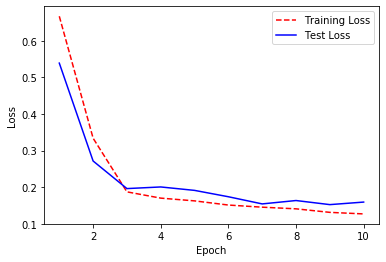

In [16]:
import matplotlib.pyplot as plt
training_loss = history.history['loss']
test_loss = history.history['val_loss']
epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Test LSTM

In [17]:
test_results = model.test_on_batch(
    X_test,
    y=y_test,
    sample_weight=None,
    reset_metrics=True
)
print(list(zip(model.metrics_names, test_results)))

[('loss', 0.14664209), ('accuracy', 0.9565591)]


In [18]:
y_pred = model.predict(X_test).round()
y_pred = list(map(lambda x: int(x[0]), y_pred))
confusion = tf.math.confusion_matrix(labels=y_test, predictions=y_pred, num_classes=2)
confusion = confusion.numpy()

In [19]:
fp = confusion[0][1]
tn = confusion[0][0]
fp_rate = float(fp / (fp+tn))
print(f"False Positive Rate: {round(fp_rate*100,2)}%")

False Positive Rate: 1.98%


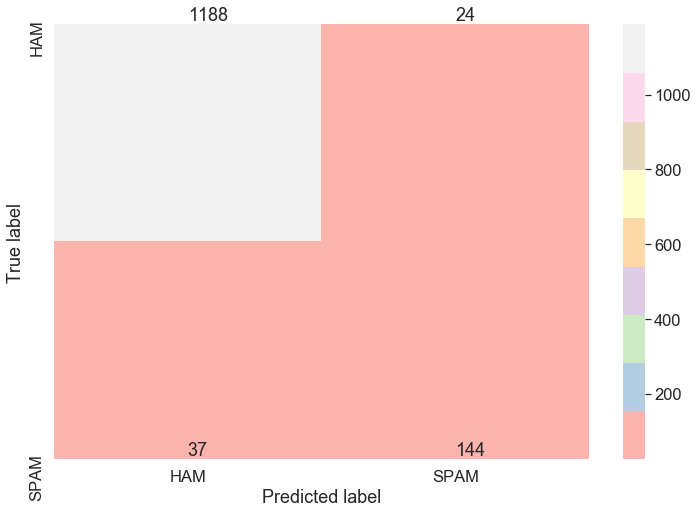

In [20]:
import seaborn as sns

df_cm = pd.DataFrame(confusion, index = ["HAM", "SPAM"],
                  columns = ["HAM", "SPAM"])
plt.figure(figsize = (12,8))
sns.set(font_scale=1.5)
annot_kws = {"ha": 'left',"va": 'bottom'}
hm = sns.heatmap(df_cm, cmap="Pastel1", fmt="d", annot=True, annot_kws=annot_kws)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Test Sample Sentences
This function allows us to make predictions on arbitrary sentences using the trained model.

In [21]:
def test_sentence(sentence):
    s = encode_sentence(sentence, embeddings)
    s = s.reshape((1,s.shape[0],s.shape[1]))
    prediction = model.predict(s)[0][0]
    if prediction >= 0.5:
        print("It's SPAM!")
    else:
        print("It's HAM!")
    print(f"Sigmoid: {prediction}")

In [22]:
test_sentence("""Enter to win $25,000 and get a Free Hotel Night! Just click 
    here for a $1 trial membership in NetMarket, the Internet's
    premier discount shopping site:
    http://www.netmarket.com/MEM/scripts/outsidePromo.asp?ref=yoyo_shp01""")
test_sentence("""My system has been down for the past 48 hours. Please help.""")

It's SPAM!
Sigmoid: 0.8507626056671143
It's HAM!
Sigmoid: 0.01890821009874344
